In [1635]:
# importing all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.datasets import make_classification

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [1636]:
# reading the files into dataframes
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [1637]:
# replacing indices in the training and testing dataframes with ID column
df_train.set_index('Id', inplace = True)
df_test.set_index('Id', inplace = True)

In [1638]:
df_train.describe()

,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [1639]:
# Homes selling for under $30,000 appear to be outliers
df_train['SalePrice'].sort_values(ascending = True)

Id
182      12789
1554     13100
727      34900
2844     35000
2881     35311
         ...  
2333    556581
434     582933
2451    584500
1638    591587
45      611657
Name: SalePrice, Length: 2051, dtype: int64

## Cleaning Data ##

In [1640]:
# While running all models, we have found 2 extraordinary outliers
df_train.drop([182, 1554, 2181, 1499], inplace = True)


### Replacing Null Values ###

In [1641]:
# We need to convert the Ordinal string data into numbers to feed into our linear regression model
# Data dictionary provided in this project reveals the ranking system in English. We have interpretted these to numbers. 
# need to provide a link for this in the README

rating_dict = {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1, np.nan : 0, 'NA': 0}
bsmt_expo_dict = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0, 'NA': 0}
bsmt_fin_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0, 'NA': 0}
electrical_dict = {'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1, np.nan: 0, 'NA': 0}
fence_dict = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.nan: 0, 'NA': 0}
functional_dict = {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal':1, np.nan: 0, 'NA': 0}
garage_finish_dict = {'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0, 'NA': 0}
land_slope_dict = {'Gtl': 3, 'Mod': 2, 'Sev': 1, np.nan: 0, 'NA': 0}
lot_shape_dict = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1, np.nan: 0, 'NA': 0}
paved_drive_dict = {'Y': 3, 'P': 2, 'N': 1, np.nan: 0, 'NA': 0}
pool_qc_dict = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, np.nan: 0, 'NA': 0}
utilities_dict = {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1, np.nan: 0, 'NA': 0}

In [1642]:
# Converting ordinal features from TRAINING data into numbers
df_train['Bsmt Cond'].replace(rating_dict, inplace = True)
df_train['Bsmt Qual'].replace(rating_dict, inplace = True)
df_train['Exter Cond'].replace(rating_dict, inplace = True)
df_train['Exter Qual'].replace(rating_dict, inplace = True)
df_train['Fireplace Qu'].replace(rating_dict, inplace = True)
df_train['Garage Cond'].replace(rating_dict, inplace = True) 
df_train['Garage Qual'].replace(rating_dict, inplace = True)
df_train['Heating QC'].replace(rating_dict, inplace = True)
df_train['Kitchen Qual'].replace(rating_dict, inplace = True)
df_train['BsmtFin Type 1'].replace(bsmt_fin_dict, inplace = True)
df_train['BsmtFin Type 2'].replace(bsmt_fin_dict, inplace = True)
df_train['Bsmt Exposure'].replace(bsmt_expo_dict, inplace = True)
df_train['Electrical'].replace(electrical_dict, inplace = True)
df_train['Fence'].replace(fence_dict, inplace = True)
df_train['Functional'].replace(functional_dict, inplace = True)
df_train['Garage Finish'].replace(garage_finish_dict, inplace = True)
df_train['Land Slope'].replace(land_slope_dict, inplace = True)
df_train['Lot Shape'].replace(lot_shape_dict, inplace = True)
df_train['Paved Drive'].replace(paved_drive_dict, inplace = True)
df_train['Pool QC'].replace(pool_qc_dict, inplace = True)
df_train['Utilities'].replace(utilities_dict, inplace = True)

In [1643]:
# Converting ordinal features from TESTING data into numbers
df_test['Bsmt Cond'].replace(rating_dict, inplace = True)
df_test['Bsmt Qual'].replace(rating_dict, inplace = True)
df_test['Exter Cond'].replace(rating_dict, inplace = True)
df_test['Exter Qual'].replace(rating_dict, inplace = True)
df_test['Fireplace Qu'].replace(rating_dict, inplace = True)
df_test['Garage Cond'].replace(rating_dict, inplace = True) 
df_test['Garage Qual'].replace(rating_dict, inplace = True)
df_test['Heating QC'].replace(rating_dict, inplace = True)
df_test['Kitchen Qual'].replace(rating_dict, inplace = True)
df_test['BsmtFin Type 1'].replace(bsmt_fin_dict, inplace = True)
df_test['BsmtFin Type 2'].replace(bsmt_fin_dict, inplace = True)
df_test['Bsmt Exposure'].replace(bsmt_expo_dict, inplace = True)
df_test['Electrical'].replace(electrical_dict, inplace = True)
df_test['Fence'].replace(fence_dict, inplace = True)
df_test['Functional'].replace(functional_dict, inplace = True)
df_test['Garage Finish'].replace(garage_finish_dict, inplace = True)
df_test['Land Slope'].replace(land_slope_dict, inplace = True)
df_test['Lot Shape'].replace(lot_shape_dict, inplace = True)
df_test['Paved Drive'].replace(paved_drive_dict, inplace = True)
df_test['Pool QC'].replace(pool_qc_dict, inplace = True)
df_test['Utilities'].replace(utilities_dict, inplace = True)

In [1644]:
# checking null values in TRAINING
df_train.isnull().sum().sort_values(ascending = False).head(16)

Misc Feature      1983
Alley             1907
Lot Frontage       330
Garage Yr Blt      114
Garage Type        113
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Area          1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Cars          1
BsmtFin SF 1         1
SalePrice            0
dtype: int64

In [1645]:
# checking null values of TESTING data.
df_test.isnull().sum().sort_values(ascending = False).head(8)

Misc Feature     837
Alley            820
Lot Frontage     160
Garage Yr Blt     45
Garage Type       44
Mas Vnr Type       1
Mas Vnr Area       1
Exter Qual         0
dtype: int64

In [1646]:
# creating dictionary to replace ALL null values
# nominal features will be replaced with 'None'
nominal_dict = {np.nan:'None'}

# Continuous features will be replaced with the mean values of those features.
lot_frontage_dict = {np.nan: df_train['Lot Frontage'].mean()}
mas_vnr_area_dict = {np.nan: df_train['Mas Vnr Area'].mean()}
bsmtFin_SF_2_dict = {np.nan: df_train['BsmtFin SF 2'].mean()}
garage_area_dict = {np.nan: df_train['Garage Area'].mean()}
bmst_unf_sf_dict = {np.nan: df_train['Bsmt Unf SF'].mean()}
total_bsmt_sf_dict = {np.nan: df_train['Total Bsmt SF'].mean()}
bmst_fin_sf_1_dict = {np.nan: df_train['BsmtFin SF 1'].mean()}

# Discrete features will be replaced with the median values
garage_yr_blt_dict = {np.nan: df_train['Garage Yr Blt'].median()}
bsmt_full_bath_dict = {np.nan: df_train['Bsmt Full Bath'].median()}
bsmt_half_bath_dict = {np.nan: df_train['Bsmt Half Bath'].median()}
garage_cars_dict = {np.nan: df_train['Garage Cars'].median()}

In [1647]:
# Replacing nulls in TRAINING data
# Nominal features
df_train['Garage Type'].replace(nominal_dict, inplace = True)
df_train['Mas Vnr Type'].replace(nominal_dict, inplace = True)
df_train['Misc Feature'].replace(nominal_dict, inplace = True)
df_train['Alley'].replace(nominal_dict, inplace = True)

# remaining features
df_train['Lot Frontage'].replace(lot_frontage_dict, inplace = True)
df_train['Mas Vnr Area'].replace(mas_vnr_area_dict, inplace = True)
df_train['Garage Yr Blt'].replace(garage_yr_blt_dict, inplace = True)
df_train['Bsmt Full Bath'].replace(bsmt_full_bath_dict, inplace = True)
df_train['Bsmt Half Bath'].replace(bsmt_half_bath_dict, inplace = True)
df_train['BsmtFin SF 2'].replace(bsmtFin_SF_2_dict, inplace = True)
df_train['Garage Cars'].replace(garage_cars_dict, inplace = True)
df_train['Garage Area'].replace(garage_area_dict, inplace = True)
df_train['Bsmt Unf SF'].replace(bmst_unf_sf_dict, inplace = True)
df_train['Total Bsmt SF'].replace(total_bsmt_sf_dict, inplace = True)
df_train['BsmtFin SF 1'].replace(bmst_fin_sf_1_dict, inplace = True)

In [1648]:
# Replacing nulls in TESTING data
# nominal features
df_test['Garage Type'].replace(nominal_dict, inplace = True)
df_test['Mas Vnr Type'].replace(nominal_dict, inplace = True)
df_test['Misc Feature'].replace(nominal_dict, inplace = True)
df_test['Alley'].replace(nominal_dict, inplace = True)

# remaining features
df_test['Lot Frontage'].replace(lot_frontage_dict, inplace = True)
df_test['Mas Vnr Area'].replace(mas_vnr_area_dict, inplace = True)
df_test['Garage Yr Blt'].replace(garage_yr_blt_dict, inplace = True)
df_test['Bsmt Full Bath'].replace(bsmt_full_bath_dict, inplace = True)
df_test['Bsmt Half Bath'].replace(bsmt_half_bath_dict, inplace = True)
df_test['BsmtFin SF 2'].replace(bsmtFin_SF_2_dict, inplace = True)
df_test['Garage Cars'].replace(garage_cars_dict, inplace = True)
df_test['Garage Area'].replace(garage_area_dict, inplace = True)
df_test['Bsmt Unf SF'].replace(bmst_unf_sf_dict, inplace = True)
df_test['Total Bsmt SF'].replace(total_bsmt_sf_dict, inplace = True)
df_test['BsmtFin SF 1'].replace(bmst_fin_sf_1_dict, inplace = True)

In [1649]:
# checking remaining null values in the TRAINING data
df_train.isnull().sum().sort_values(ascending = False).head(2)

SalePrice    0
Sale Type    0
dtype: int64

In [1650]:
# checking remaining null values in the TESTING data
df_test.isnull().sum().sort_values(ascending = False).head(2)

Sale Type     0
Exter Cond    0
dtype: int64

### Get Dummies

In [1651]:
# Getting dummies for all Nominal Features
nominal_features = ['Mas Vnr Type', 'MS SubClass', 'MS Zoning', 'Street', 'Misc Feature', 'Land Contour', 
                     'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
                     'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Alley', 'Foundation',
                     'Garage Type', 'Heating', 'Central Air', 'Sale Type']

In [1652]:
# getting Dummies for categorizations - Nominal features
df_train = pd.get_dummies(data = df_train, columns = nominal_features)
df_test = pd.get_dummies(data = df_test, columns = nominal_features)

In [1653]:
df_test.shape

(878, 222)

In [1654]:
df_train.shape

(2047, 232)

In [1655]:
set(df_test.columns) - set(df_train.columns)

{'Exterior 1st_PreCast',
 'Exterior 2nd_Other',
 'Exterior 2nd_PreCast',
 'Heating_Floor',
 'Mas Vnr Type_CBlock',
 'Roof Matl_Metal',
 'Roof Matl_Roll',
 'Sale Type_VWD'}

In [1656]:
set(df_train.columns) - set(df_test.columns)

{'Condition 2_Artery',
 'Condition 2_PosN',
 'Condition 2_RRAe',
 'Condition 2_RRAn',
 'Condition 2_RRNn',
 'Exterior 1st_CBlock',
 'Exterior 1st_ImStucc',
 'Exterior 1st_Stone',
 'Exterior 2nd_Stone',
 'Heating_OthW',
 'Heating_Wall',
 'MS SubClass_150',
 'MS Zoning_A (agr)',
 'Misc Feature_TenC',
 'Neighborhood_GrnHill',
 'Neighborhood_Landmrk',
 'Roof Matl_Membran',
 'SalePrice'}

### Same columns on both dataframes ###

In [1657]:
# provides the columns that exist in Train that do NOT exist in Test (and vice versa0)
add_columns_to_train = set(df_test.columns) - set(df_train.columns)
add_columns_to_test = set(df_train.columns) - set(df_test.columns)

# Add columns that were exclusive to test.csv to df_train (and vice versa)
for col in add_columns_to_train:
    df_train[col] = 0
for col in add_columns_to_test:
    df_test[col] = 0

# Reorder df_train to match df_test columns
df_train = df_train[df_test.columns]

# Removing SalePrice from Test
df_test = df_test.drop('SalePrice', axis = 1)

In [1658]:
df_train.shape

(2047, 240)

In [1659]:
df_test.shape

(878, 239)

In [1660]:
# drops first column of the group of dummy columns 
for nom in nominal_features:
    dummy_list = [col for col in df_train.columns if nom in col]
    df_train.drop(columns = dummy_list[0], inplace = True)
    df_test.drop(columns = dummy_list[0], inplace = True)

In [1661]:
set(df_train.columns) - set(df_test.columns)

{'SalePrice'}

In [1662]:
# converting the object data types into float64 for both test and training data so we can run a regression
df_train = df_train.astype('float64')
df_test = df_test.astype('float64')

In [1663]:
df_train.shape

(2047, 218)

In [1664]:
df_test.shape

(878, 217)

### Reviewing Correlations

In [1665]:
# finding correlation values
pd.set_option('display.max_rows', 259)
df_train.corr()[['SalePrice']].sort_values('SalePrice')

,SalePrice
Mas Vnr Type_None,-0.410991
Garage Type_Detchd,-0.370462
Foundation_CBlock,-0.358459
Lot Shape,-0.295987
MS Zoning_RM,-0.281050
PID,-0.253634
Roof Style_Gable,-0.249532
MS SubClass_30,-0.245948
Garage Type_None,-0.232051
Sale Type_WD,-0.213217


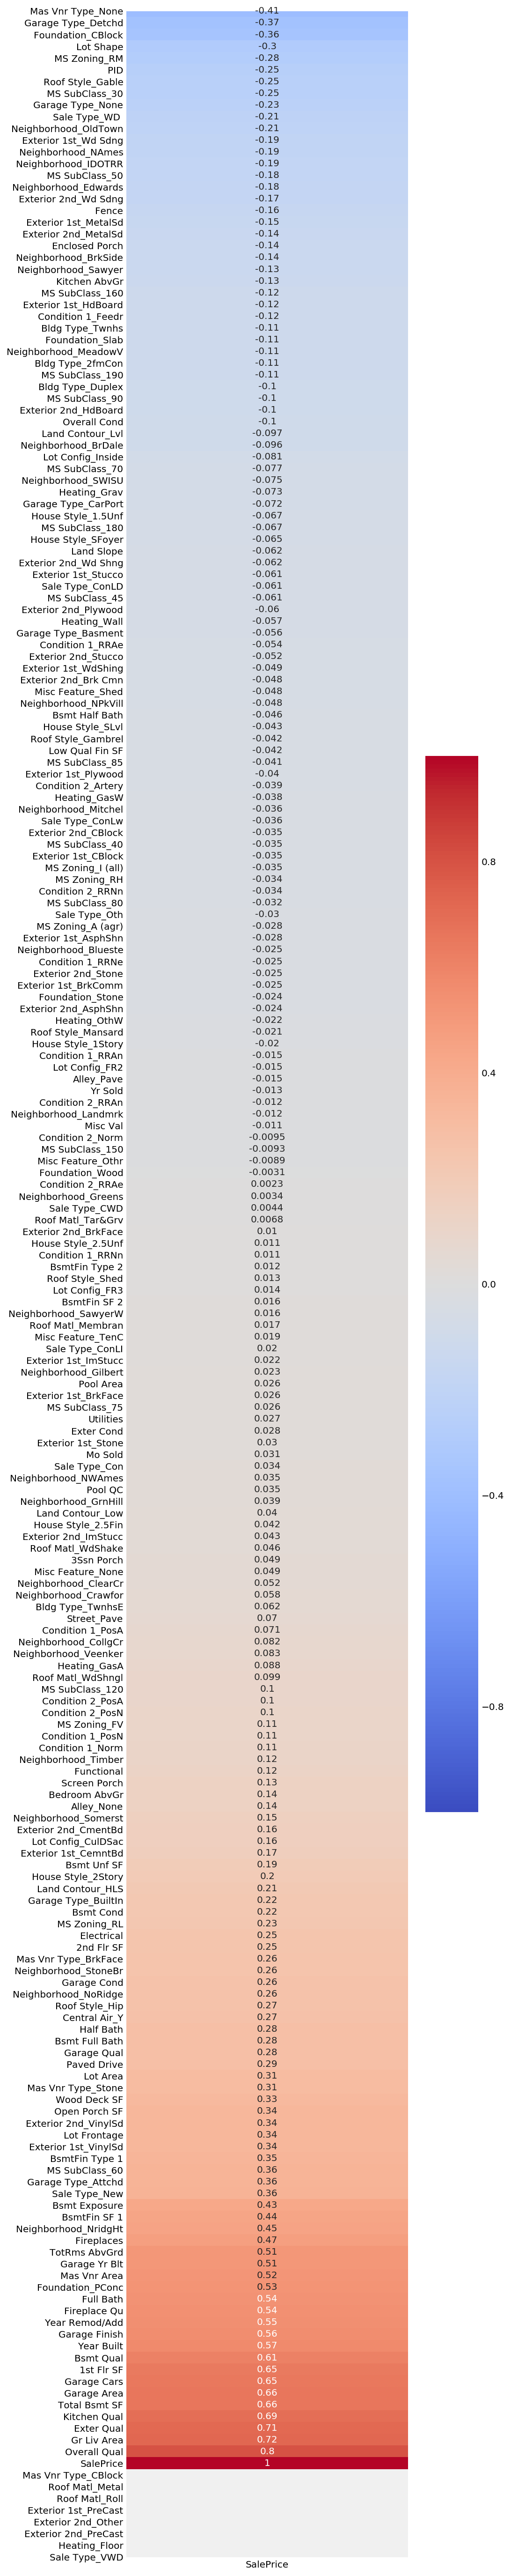

In [1666]:
plt.figure(figsize = (6, 50)) # this figsizes are in inches wide and tall
# need to specify which column you want to sort by, even though there is only 1 column
sns.heatmap(df_train.corr()[['SalePrice']].sort_values('SalePrice'),
            cmap = 'coolwarm',
            vmin = -1,
            vmax = 1,
            annot=True);

### Feature Selection

In [1667]:
# We will keep all features above 0.5 correlation, exclude the features below 0.5 correlation.
# Dropping each dummied nominal feature column

for col in df_train.columns:
    for nom in nominal_features:
        if nom in col:
            df_train.drop(columns = col, inplace = True)
    
for col in df_test.columns:
    for nom in nominal_features:
        if nom in col:
            df_test.drop(columns = col, inplace = True)

In [1668]:
# Listing the remaining features to drop

excluded_features = ['PID',
                     
#continuous features
                     '2nd Flr SF', '3Ssn Porch', 'Bsmt Unf SF', 'BsmtFin SF 2', 'Enclosed Porch',
                     'Low Qual Fin SF', 'Misc Val', 'Pool Area', 
                     'Screen Porch',                  
# ordinal features
                     'Bsmt Cond', 'BsmtFin Type 2', 'Electrical', 'Exter Cond', 
                     'Fence', 'Functional', 'Garage Cond', 'Garage Qual', 'Land Slope', 'Lot Shape', 'Overall Cond', 
                     'Paved Drive', 'Pool QC', 'Utilities',

# discrete features
                     'Bedroom AbvGr', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplaces', 'Half Bath', 'Kitchen AbvGr',
                     'Mo Sold', 'Yr Sold']

# testing features with correlation between 0.3-0.5
# ordinal
# Bsmt Exposure
# BsmtFin Type 1

# Continuous
# BsmtFin SF 1
# Lot Area
# Lot Frontage
# Open Porch SF
# Wood Deck SF

In [1669]:
# dropping remaining features for both dataframes
df_train.drop(columns = excluded_features, inplace = True)
df_test.drop(columns = excluded_features, inplace = True)

In [1670]:
# finding correlation values
df_train.corr()[['SalePrice']].sort_values('SalePrice')

,SalePrice
Lot Area,0.305112
Wood Deck SF,0.326920
Open Porch SF,0.337887
Lot Frontage,0.340185
BsmtFin Type 1,0.348869
Bsmt Exposure,0.425174
BsmtFin SF 1,0.444711
TotRms AbvGrd,0.508719
Garage Yr Blt,0.512986
Mas Vnr Area,0.516374


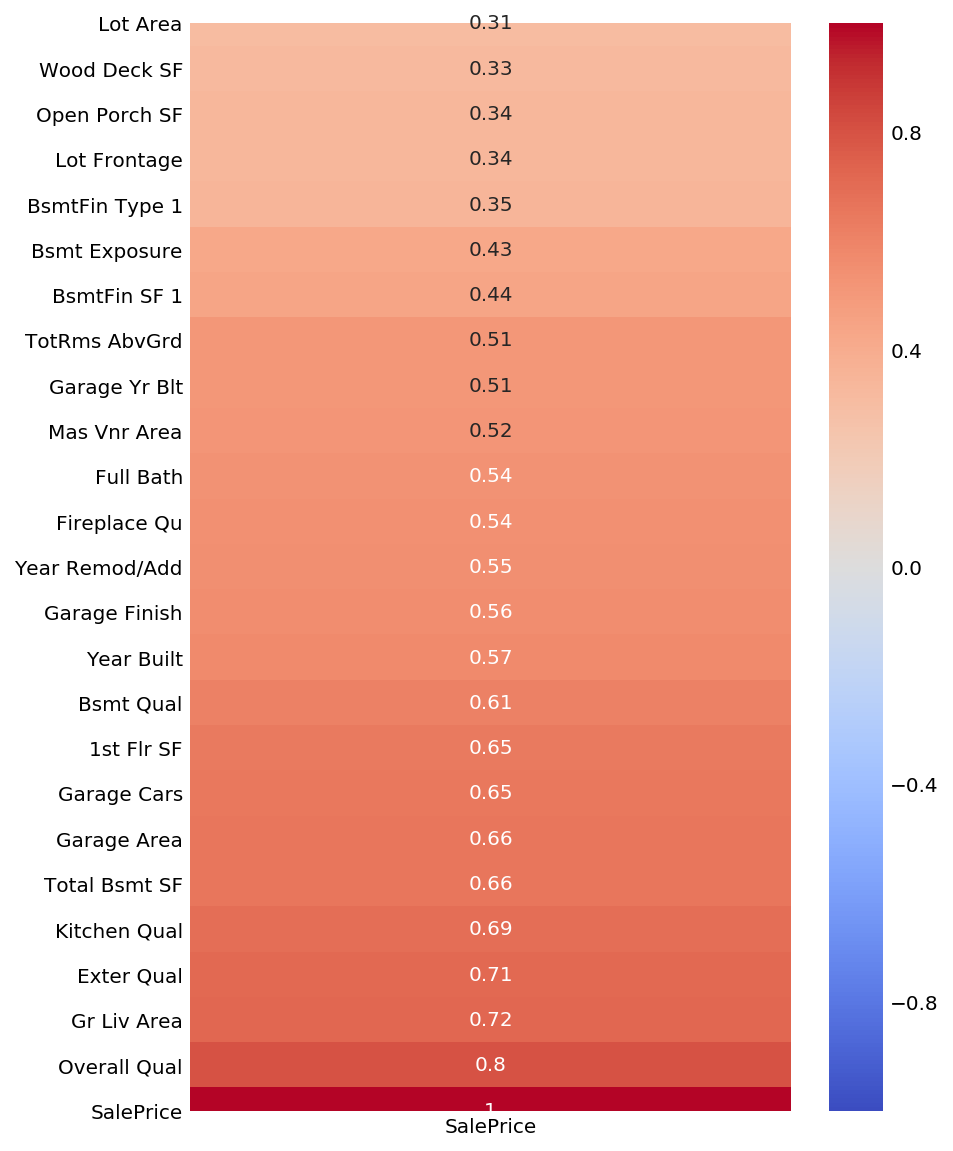

In [1671]:
plt.figure(figsize = (6, 10)) # this figsizes are in inches wide and tall
# need to specify which column you want to sort by, even though there is only 1 column
sns.heatmap(df_train.corr()[['SalePrice']].sort_values('SalePrice'),
            cmap = 'coolwarm',
            vmin = -1,
            vmax = 1,
            annot=True);

In [1672]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 109 to 10
Data columns (total 25 columns):
Lot Frontage      2047 non-null float64
Lot Area          2047 non-null float64
Overall Qual      2047 non-null float64
Year Built        2047 non-null float64
Year Remod/Add    2047 non-null float64
Mas Vnr Area      2047 non-null float64
Exter Qual        2047 non-null float64
Bsmt Qual         2047 non-null float64
Bsmt Exposure     2047 non-null float64
BsmtFin Type 1    2047 non-null float64
BsmtFin SF 1      2047 non-null float64
Total Bsmt SF     2047 non-null float64
1st Flr SF        2047 non-null float64
Gr Liv Area       2047 non-null float64
Full Bath         2047 non-null float64
Kitchen Qual      2047 non-null float64
TotRms AbvGrd     2047 non-null float64
Fireplace Qu      2047 non-null float64
Garage Yr Blt     2047 non-null float64
Garage Finish     2047 non-null float64
Garage Cars       2047 non-null float64
Garage Area       2047 non-null float64
Wood Deck SF 

## Testing the model

In [1673]:
# Dropping remaining outliers after we tested the models again
df_train.drop([1183, 1783, 2333, 434, 1641], inplace = True)

# from the top
# 182, 1554, 2181, 1499

# from the old linear model, this is what I dropped
# 2181, 1499, 434, 1183, 1783, 2333

In [1674]:
# setting X and y variables
X = df_train.drop(columns = 'SalePrice')
y = df_train['SalePrice']

In [1675]:
#OLS on a test
X_ols = sm.add_constant(X)
est = sm.OLS(y, X.astype(float)).fit()
est.summary()

C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              4646.
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                        0.00
Time:                        00:39:47   Log-Likelihood:                         -23680.
No. Observations:                2042   AIC:                                  4.741e+04
Df Residuals:                    2018   BIC:                                  4.754e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Lot Frontage     155.7526     33.487      4.651      0.000      90.079     221.426
Lot Area           0.7429      0.102      7.311      0.000       0.544       0.942
Overall Qual    1.204e+04    800.037     15.054      0.000    1.05e+04    1.36e+04
Year Built        27.7794     36.679      0.757      0.449     -44.153      99.711
Year Remod/Add   -51.3188     33.400     -1.537      0.125    -116.820      14.183
Mas Vnr Area      37.6651      4.036      9.332      0.000      29.749      45.581
Exter Qual      1.964e+04   1729.416     11.358      0.000    1.63e+04     2.3e+04
Bsmt Qual       4418.7708   1121.307      3.941      0.000    2219.730    6617.812
Bsmt Exposure   3259.5513    660.093      4.938      0.000    1965.016    4554.087
BsmtFin Type 1  -874.5216    430.289     -2.032      0.042   -1718.378     -30.665
BsmtFin SF 1      25.5145      2.185     11.679      0.000      21.230      29.799
Total Bsmt SF     11.5112      2.922      3.940      0.000       5.782      17.241
1st Flr SF         7.0857      3.182      2.226      0.026       0.844      13.327
Gr Liv Area       45.5521      2.769     16.450      0.000      40.121      50.983
Full Bath      -1336.2831   1511.875     -0.884      0.377   -4301.282    1628.716
Kitchen Qual    1.303e+04   1400.968      9.302      0.000    1.03e+04    1.58e+04
TotRms AbvGrd   -395.4090    690.278     -0.573      0.567   -1749.141     958.323
Fireplace Qu    1955.6616    403.584      4.846      0.000    1164.177    2747.146
Garage Yr Blt    -57.6376     39.893     -1.445      0.149    -135.873      20.597
Garage Finish   1742.0310    909.767      1.915      0.056     -42.149    3526.211
Garage Cars     -911.2722   1918.346     -0.475      0.635   -4673.417    2850.873
Garage Area       31.6282      6.701      4.720      0.000      18.487      44.770
Wood Deck SF      13.8376      4.983      2.777      0.006       4.066      23.609
Open Porch SF     14.4289      9.693      1.489      0.137      -4.579      33.437
==============================================================================
Omnibus:                      348.570   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1684.236
Skew:                           0.727   Prob(JB):                         0.00
Kurtosis:                       7.205   Cond. No.                     4.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Train Test Split

In [1676]:
# running Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [1677]:
# Instantiate Standard Scaler.
sc = StandardScaler()

# Fit AND transform Standard Scaler to data in one step.
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [1678]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [1679]:
# plot predictions function
def plot_predictions(predictions, regression_type):

    # plotting training data for Y hat vs actual Y to find outliers
    plt.figure(figsize=(10,5))

    # Generate a scatterplot of carat versus price.
    plt.scatter(predictions,
                y_train,
                alpha = 0.5)

    plt.xlabel('Predicted Sale Price', fontsize = 15)
    plt.ylabel('Actual Sale Price', fontsize = 15)
    plt.title("Predicting Housing Prices with "+regression_type , fontsize = 24)

    # attempting to annot each value
    training = 0
    for i, txt in y_train.iteritems():
        plt.annotate(i, (predictions[training], y_train[i]))
        training += 1

    # plot the regression line
    plt.plot(predictions,
             predictions,
             color = 'red');
    return

### Linear Regression

In [1680]:
# Linear Regression
lr = LinearRegression()
lr.fit(Z_train, y_train_log) # or y_train_log

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1681]:
# predicting values for linear regression
y_hat_lr_train = lr.predict(Z_train) # or y_hat_lr_train_log
y_hat_lr_test = lr.predict(Z_test) # or y_hat_lr_test_log

In [1682]:
# need to test
preds_lr_train = np.exp(y_hat_lr_train)
preds_lr_test = np.exp(y_hat_lr_test)

In [1683]:
print(lr.score(Z_train, y_train_log))
print(lr.score(Z_test, y_test_log))

0.9020055247645876
0.8913138823482119


In [1684]:
# this is the 5 fold cross val score
cross_val_score(lr, Z_train, y_train_log, cv=5).mean()

0.8973548710579387

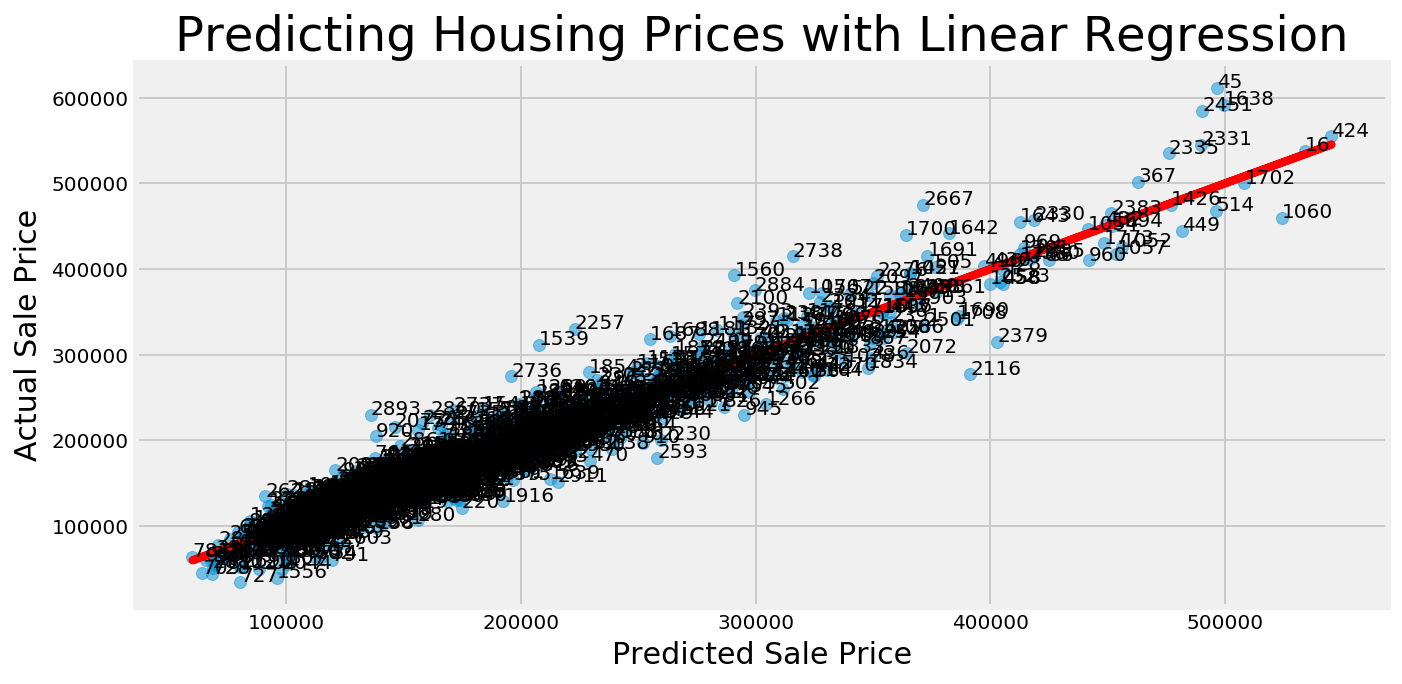

In [1685]:
plot_predictions(preds_lr_train, 'Linear Regression')

In [1686]:
# Mean Squared Errors for Y Training
np.sqrt(mean_squared_error(y_train, preds_lr_train))

21223.693119436437

In [1687]:
# Mean Squared Errors for Y Test
np.sqrt(mean_squared_error(y_test, preds_lr_test))

22320.98284359168

### Ridge Regression ###

In [1688]:
# Set up a list of ridge alphas to check.
# Generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.
ridge_alphas = np.linspace(10, 15, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(
    alphas = ridge_alphas,
    scoring = "r2",
    cv = 5) #How many folds

# Fit model using best ridge alpha!
ridge_cv.fit(Z_train, y_train_log) # or y_train log 

RidgeCV(alphas=array([10.        , 10.05050505, 10.1010101 , 10.15151515, 10.2020202 ,
       10.25252525, 10.3030303 , 10.35353535, 10.4040404 , 10.45454545,
       10.50505051, 10.55555556, 10.60606061, 10.65656566, 10.70707071,
       10.75757576, 10.80808081, 10.85858586, 10.90909091, 10.95959596,
       11.01010101, 11.06060606, 11.11111111, 11.16161616, 11.21212121,
       11.26262626, 11.31313131, 11.36363636, 11.4...
       13.78787879, 13.83838384, 13.88888889, 13.93939394, 13.98989899,
       14.04040404, 14.09090909, 14.14141414, 14.19191919, 14.24242424,
       14.29292929, 14.34343434, 14.39393939, 14.44444444, 14.49494949,
       14.54545455, 14.5959596 , 14.64646465, 14.6969697 , 14.74747475,
       14.7979798 , 14.84848485, 14.8989899 , 14.94949495, 15.        ]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring='r2',
        store_cv_values=False)

In [1689]:
# Optimal Alpha
ridge_cv.alpha_

11.767676767676768

In [1690]:
print(ridge_cv.score(Z_train, y_train_log))
print(ridge_cv.score(Z_test, y_test_log))

0.9019701738681982
0.8909976123114369


In [1691]:
# fitting
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(Z_train, y_train_log) # or y_train_log

Ridge(alpha=11.767676767676768, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [1692]:
# predicting values with Ridge
y_hat_ridge_train = ridge.predict(Z_train) # these are log versions
y_hat_ridge_test = ridge.predict(Z_test)

In [1693]:
# Final Ridge predictions
preds_ridge_train = np.exp(y_hat_ridge_train)
preds_ridge_test = np.exp(y_hat_ridge_test)

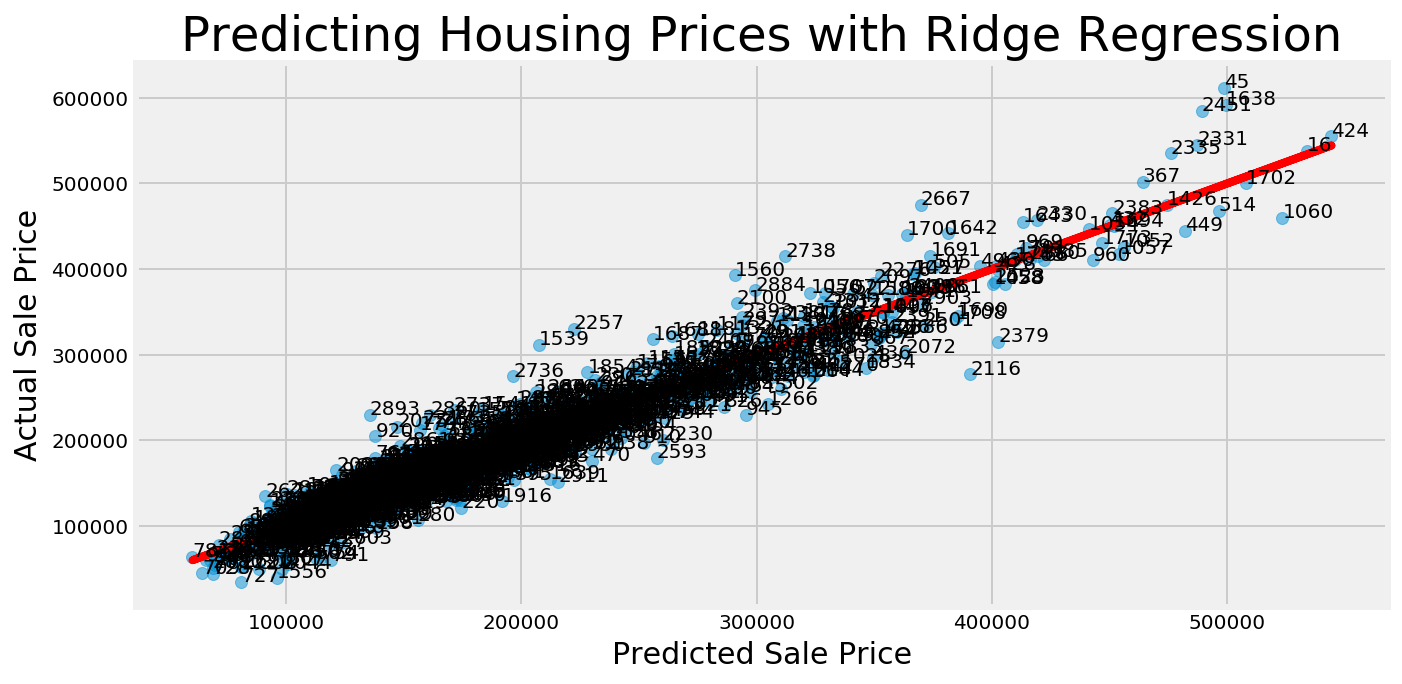

In [1694]:
plot_predictions(preds_ridge_train, 'Ridge Regression')

In [1695]:
# Mean Squared Errors for Y Training
np.sqrt(mean_squared_error(y_train, preds_ridge_train))

21225.15990029489

In [1696]:
# test data linear regression RMSE
np.sqrt(mean_squared_error(y_test, preds_ridge_test)) # keep updating y_test values here for the models

22346.81408441959

### LASSO

In [1697]:
# Set up a list of Lasso alphas to check.
lasso_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso = LassoCV(
    alphas = lasso_alphas,
    cv = 5,
    max_iter = 5000)

# Fit model using best ridge alpha!
lasso.fit(Z_train, y_train_log)

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=5000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [1698]:
lasso.alpha_

0.0016297508346206436

In [1699]:
print(lasso.score(Z_train, y_train_log))
print(lasso.score(Z_test, y_test_log))

0.9016680314444735
0.8913192608735647


In [1700]:
# predicting logged values with Ridge
y_hat_lasso_train = lasso.predict(Z_train)
y_hat_lasso_test = lasso.predict(Z_test)

In [1701]:
# Final Ridge predictions
preds_lasso_train = np.exp(y_hat_lasso_train)
preds_lasso_test = np.exp(y_hat_lasso_test)

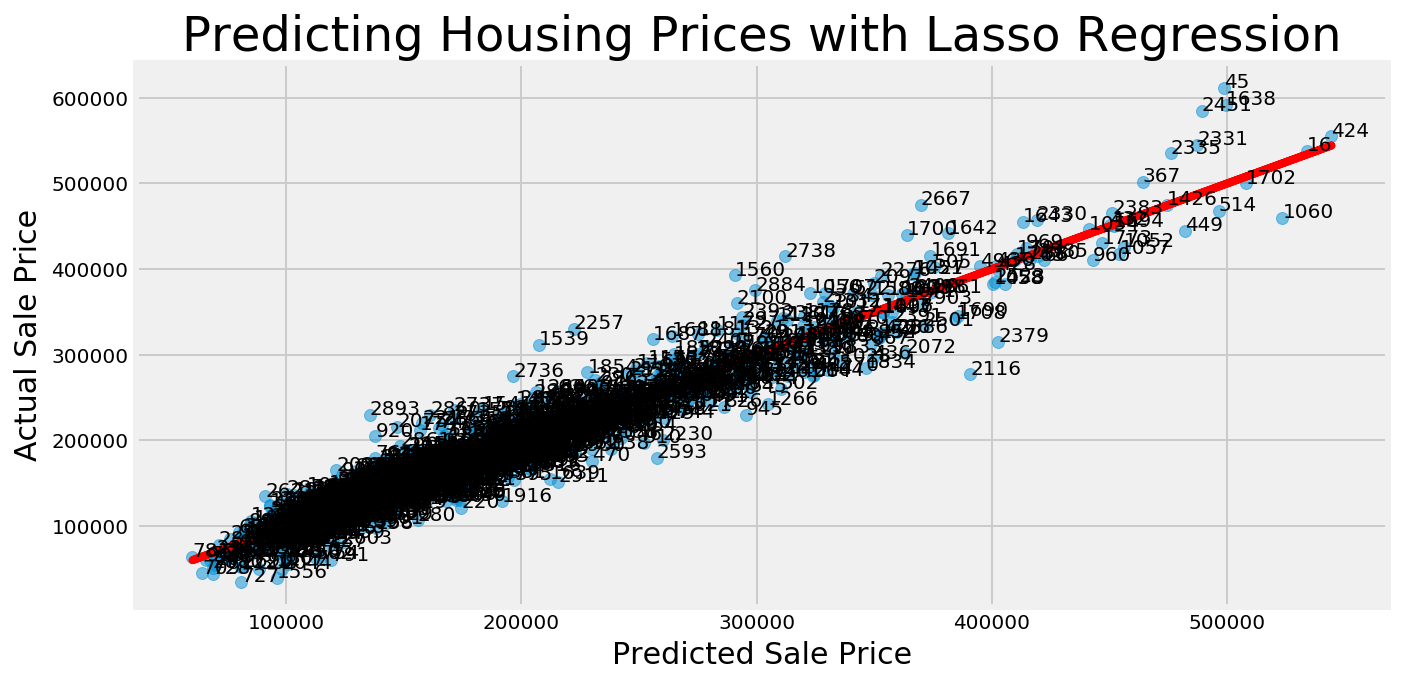

In [1702]:
plot_predictions(preds_ridge_train, 'Lasso Regression')

In [1703]:
# Mean Squared Errors for Y Training
np.sqrt(mean_squared_error(y_train, preds_lasso_train))

21235.989952558055

In [1704]:
# test data linear regression RMSE
np.sqrt(mean_squared_error(y_test, preds_lasso_test))

22184.010270605213

In [1708]:
lasso.coef_

array([ 0.01923688,  0.02470293,  0.09362769,  0.04282247,  0.04177323,
        0.00255886,  0.01504317,  0.00890553,  0.00841392,  0.0173364 ,
        0.03494683,  0.03794842,  0.00898387,  0.11185617, -0.00168154,
        0.02840694,  0.        ,  0.0312647 , -0.00640846,  0.01345946,
        0.01211206,  0.02523801,  0.00265108, -0.        ])

### ElasticNet Regression

In [1705]:
# Set up a list of alphas to check.
enet_alphas = np.linspace(0.001, 0.0012, 1000)

# Set up our l1 ratio.
enet_ratio = 0.5

# Instantiate model.
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

# Fit model using optimal alpha.
enet_model = enet_model.fit(Z_train, y_train_log)

# Generate predictions.
enet_model_preds = enet_model.predict(Z_test)
enet_model_preds_train = enet_model.predict(Z_train)

# Evaluate model.
print(enet_model.score(Z_train, y_train_log))
print(enet_model.score(Z_test, y_test_log))

0.9019413751158746
0.8914522607227942


In [1706]:
# Here is the optimal value of alpha.
enet_model.alpha_

0.0012

In [1707]:
# Final Enet Predictions
preds_enet_train = np.exp(enet_model_preds_train)
preds_enet_test = np.exp(enet_model_preds)

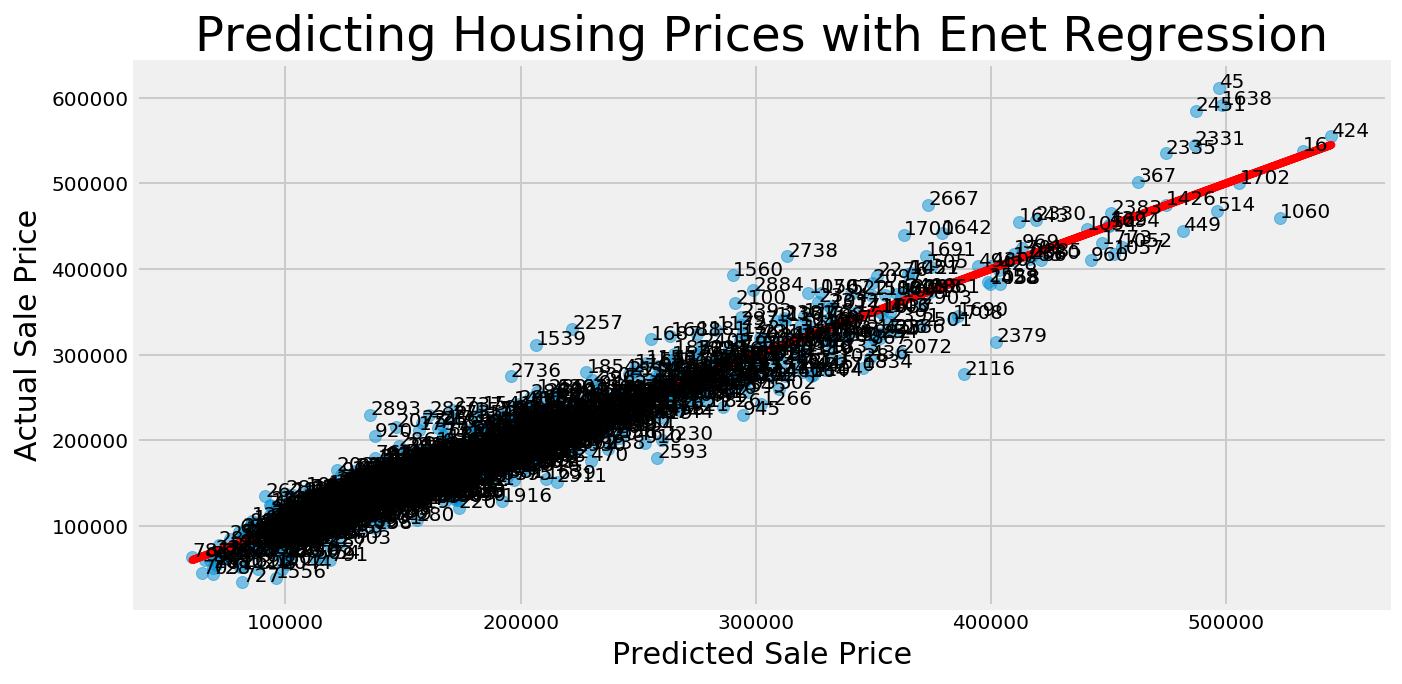

In [1709]:
plot_predictions(preds_enet_train, 'Enet Regression')

### Kaggle

In [1710]:
X_kaggle = df_test

In [1711]:
X_kaggle_sc = sc.transform(X_kaggle)

In [1422]:
# # Ridge Regression
# preds_kaggle_log = ridge.predict(X_kaggle_sc)
# X_kaggle['SalePrice'] = np.exp(preds_kaggle_log)

In [1423]:
# # LASSO Regression
# preds_kaggle_log = lr.predict(X_kaggle_sc)
# X_kaggle['SalePrice'] = np.exp(preds_kaggle_log)

In [1712]:
# Enet Regression
preds_kaggle_log = enet_model.predict(X_kaggle_sc)
X_kaggle['SalePrice'] = np.exp(preds_kaggle_log)

In [1713]:
output = X_kaggle[['SalePrice']]

In [1714]:
# Creating CSV file
output.to_csv('./datasets/EnetRegression_CorrelationsAbove0.3_9OutliersRemoved.csv')